# Creating A Training Set From s2p data


## Import pyMez and pyMez.Code.Analysis.SParameter  

In [2]:
import os
from pyMez import *
from pyMez.Code.Analysis.SParameter import *
from pyMez.Code.DataHandlers.NISTModels import *
from pyMez.Code.DataHandlers.Translations import *
import sys
sys.path.insert(0, '..')
#from Machine_Learning import *
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


In [3]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier, SGDClassifier, PassiveAggressiveClassifier, Perceptron
from sklearn.svm import SVC
classifier_dict = {"QDA": QuadraticDiscriminantAnalysis,
                   "Bernoulli Naive Bayes": BernoulliNB,
                   "Decision Tree": DecisionTreeClassifier,
                   "Random Forest": RandomForestClassifier,
                   "Ridge": RidgeClassifier,
                   "SGD": SGDClassifier,
                   "Passive Aggressive": PassiveAggressiveClassifier,
                   "Perceptron": Perceptron}

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Define the files to be imported

In [4]:
# A little different way of doing it 
# Read all the folders and create a dictionary
pretrain_folder=r"C:\Share\Scattering Parameter ML Training Set\TypeN_20190208\PreTrain"
pretrain_folders=os.listdir(pretrain_folder)
device_type_dictionary={index:value for index,value in enumerate(pretrain_folders)}
device_type_dictionary_inverse={value:index for index,value in enumerate(pretrain_folders)}
pretrain_folders=map(lambda x:os.path.join(pretrain_folder,x),pretrain_folders)

In [5]:
print(device_type_dictionary)

{0: 'Load', 1: 'Load_Position_10', 2: 'Load_Position_4', 3: 'Load_Position_5', 4: 'Load_Position_6', 5: 'Load_Position_7', 6: 'Load_Position_8', 7: 'Load_Position_9', 8: 'Open', 9: 'Open_Position_4', 10: 'Open_Position_5', 11: 'Open_Position_6', 12: 'Open_Position_7', 13: 'Short', 14: 'Short_Position_10', 15: 'Short_Position_4', 16: 'Short_Position_5', 17: 'Short_Position_6', 18: 'Short_Position_7', 19: 'Short_Position_8', 20: 'Short_Position_9', 21: 'Thru', 22: 'Thru_Position_10', 23: 'Thru_Position_4', 24: 'Thru_Position_5', 25: 'Thru_Position_6', 26: 'Thru_Position_7', 27: 'Thru_Position_8', 28: 'Thru_Position_9'}


In [6]:
def create_s2p_training_set(pretrain_folder,number_training_sets=1000,expansion_factor=1.0):
    """Given a directory containing multiple measurements this creates a list of np.arrays to 
    train a classifier"""
    pretrain_files=os.listdir(pretrain_folder)
    #print("The number of pretrain files is {0}, \nthe pretrain folder is {1}".format(len(pretrain_files), pretrain_folder))
    pretrain_files=map(lambda x:os.path.join(pretrain_folder,x),pretrain_files)
    # now open the files convert them to AsciiData Tables and find the mean and standard deviation
    first_file=Snp_to_AsciiDataTable(SNP(pretrain_files[0]))
    joined_file=first_file.copy()
    for file_name in pretrain_files[1:]:
        joined_file=joined_file+Snp_to_AsciiDataTable(SNP(file_name))
    mean_file=frequency_model_collapse_multiple_measurements(joined_file)
    std_file=frequency_model_collapse_multiple_measurements(joined_file,method="std")
    mean_array=AsciiDataTable_to_NumpyArray(mean_file,exclude_columns="Frequency")
    std_array=AsciiDataTable_to_NumpyArray(std_file,exclude_columns="Frequency")
    
    training_arrays=np.array([np.random.normal(loc=mean_value,scale=expansion_factor*std_array[index]+1*10**-9,
                                               size=number_training_sets) for index,
                              mean_value in enumerate(mean_array)])

    training_arrays=[[training_arrays[i][j] 
                      for i in range(len(mean_array))] for j in range(number_training_sets)]
    return training_arrays

def percent_correct(target_list,prediction_list):
    """Calculates the number of correct predictions"""
    number_correct=0
    for index,value in enumerate(target_list):
        if prediction_list[index]==value:
            number_correct+=1
    return 100*float(number_correct)/float(len(target_list))




In [7]:
pretrain_folders

['C:\\Share\\Scattering Parameter ML Training Set\\TypeN_20190208\\PreTrain\\Load',
 'C:\\Share\\Scattering Parameter ML Training Set\\TypeN_20190208\\PreTrain\\Load_Position_10',
 'C:\\Share\\Scattering Parameter ML Training Set\\TypeN_20190208\\PreTrain\\Load_Position_4',
 'C:\\Share\\Scattering Parameter ML Training Set\\TypeN_20190208\\PreTrain\\Load_Position_5',
 'C:\\Share\\Scattering Parameter ML Training Set\\TypeN_20190208\\PreTrain\\Load_Position_6',
 'C:\\Share\\Scattering Parameter ML Training Set\\TypeN_20190208\\PreTrain\\Load_Position_7',
 'C:\\Share\\Scattering Parameter ML Training Set\\TypeN_20190208\\PreTrain\\Load_Position_8',
 'C:\\Share\\Scattering Parameter ML Training Set\\TypeN_20190208\\PreTrain\\Load_Position_9',
 'C:\\Share\\Scattering Parameter ML Training Set\\TypeN_20190208\\PreTrain\\Open',
 'C:\\Share\\Scattering Parameter ML Training Set\\TypeN_20190208\\PreTrain\\Open_Position_4',
 'C:\\Share\\Scattering Parameter ML Training Set\\TypeN_20190208\\PreT

In [8]:
number_training_sets=1000
expansion_factor=3
sorted_device_keys=sorted(device_type_dictionary.keys())
training_array=[]
for key in sorted_device_keys:
    print("Working on {0}".format(key))
    training_array=training_array+create_s2p_training_set(os.path.join(pretrain_folder,
                                                               "{0}".format(device_type_dictionary[key])),
                                                              number_training_sets,expansion_factor=expansion_factor)
target_array=[]
for key_index,key in enumerate(sorted_device_keys):
    target_array=target_array+[key for i in range(number_training_sets)]


Working on 0
Working on 1
Working on 2
Working on 3
Working on 4
Working on 5
Working on 6
Working on 7
Working on 8
Working on 9
Working on 10
Working on 11
Working on 12
Working on 13
Working on 14
Working on 15
Working on 16
Working on 17
Working on 18
Working on 19
Working on 20
Working on 21
Working on 22
Working on 23
Working on 24
Working on 25
Working on 26
Working on 27
Working on 28


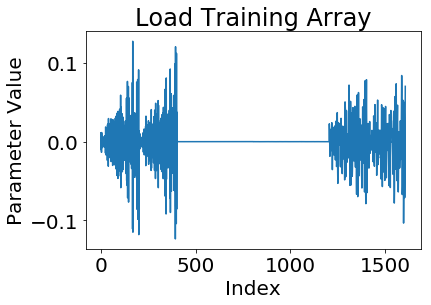

In [17]:
plt.rcParams.update({'font.size': 20})

for i in range(1):
    plt.plot(training_array[i])
plt.xlabel("Index")
plt.ylabel("Parameter Value")
plt.title("Load Training Array")
plt.show()

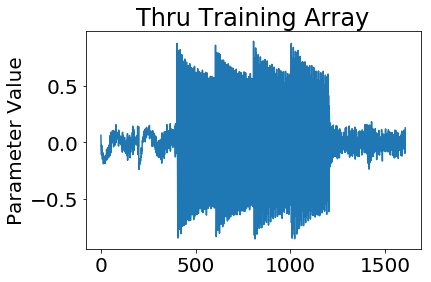

In [57]:

plt.plot(training_array[21000])
#plt.xlabel("Index")
plt.ylabel("Parameter Value")
plt.title("Thru Training Array")
plt.show()

In [60]:
len(target_array)

29000

In [143]:
classifier=QuadraticDiscriminantAnalysis()
classifier.fit(training_array,target_array)


QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariances=False, tol=0.0001)

In [144]:
base_predictions=classifier.predict(training_array)
base_correct=percent_correct(target_array,base_predictions)
print("The correct percentage is {0}".format(base_correct))

The correct percentage is 100.0


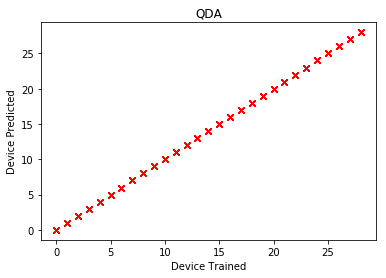

In [145]:
plt.plot(target_array,base_predictions,"rx")
plt.xlabel("Device Trained")
plt.ylabel("Device Predicted")
plt.title("QDA")
plt.show()

The correct percentage is 100.0


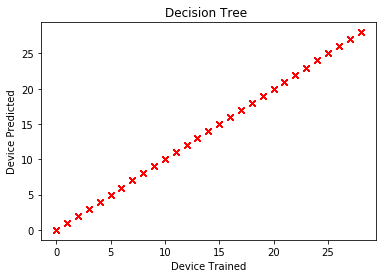

In [150]:
two_port_classifier=DecisionTreeClassifier()
two_port_classifier.fit(training_array, target_array)
d_base_predictions=two_port_classifier.predict(training_array)
d_base_correct=percent_correct(target_array,d_base_predictions)
print("The correct percentage is {0}".format(d_base_correct))
plt.plot(target_array,d_base_predictions,"rx")
plt.xlabel("Device Trained")
plt.ylabel("Device Predicted")
plt.title("Decision Tree ")
plt.show()

In [66]:
#Build a test folder from the training folders
test_folder=r"C:\Share\Scattering Parameter ML Training Set\TypeN_20190208\Test"
test_target_dictionary={}
for folder in pretrain_folders:
    device_type=folder.split("\\")[-1]
    for s2p_name in os.listdir(folder):
        s2p_path=os.path.join(folder,s2p_name)
        if os.path.isfile(s2p_path):
            s2p=S2PV1(s2p_path)
            s2p.save(os.path.join(test_folder,device_type+"_"+s2p_name))
            test_target_dictionary[device_type+"_"+s2p_name]=device_type

In [122]:
#test_folder=r"C:\Share\Scattering Parameter ML Training Set\Test Set 1"
test_files=os.listdir(test_folder)
#test_target_list=[list(device_type_dictionary.keys())[list(device_type_dictionary.values()).index(test_target_dictionary[key])] for key in test_files]
test_files=map(lambda x:os.path.join(test_folder,x),test_files)

In [22]:
len(test_files)

55

In [151]:
test_array=[]
#test_target_list=[]
for file_name in test_files:
    test_array=test_array+[AsciiDataTable_to_NumpyArray(Snp_to_AsciiDataTable(SNP(file_name)),exclude_columns="Frequency")]
    #test_target_list.append(device_type_dictionary_inverse[test_target_dictionary[os.path.basename(file_name)]])
predictions=two_port_classifier.predict(test_array)
file_name_predictions={test_files[index]:device_type_dictionary[key] for index,key in enumerate(predictions.tolist())}

In [ ]:
for key,value in file_name_predictions.iteritems():
    print("{0} is type {1}".format(os.path.basename(key),value))

In [94]:
predictions

array([ 2,  2,  2,  2,  3,  3,  3,  4,  3,  1,  1,  5,  6,  6,  5,  1,  1,
        1,  7,  7,  5,  7,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,
        5,  5,  5,  6,  1,  6,  7,  7,  7,  8,  8, 10,  8,  8, 11,  8,  8,
       11,  8, 12, 10,  8,  8,  8,  9,  9,  9, 10, 10, 10, 11, 11, 11, 12,
       12, 12, 14, 14, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17, 18, 18, 18,
       19, 19, 19, 20, 20, 20, 17, 17, 19, 18, 16, 16, 20, 17, 14, 18, 17,
       17, 14, 13, 20, 20, 14, 13, 17, 17, 17, 22, 22, 22, 23, 23, 23, 24,
       28, 23, 25, 22, 25, 26, 26, 26, 27, 27, 27, 28, 28, 28, 23, 23, 23,
       21, 23, 27, 27, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
       23])

In [152]:
accuracy=0
device_type_accuracy=0
sorted_keys=sorted(file_name_predictions.keys())
sorted_values=[file_name_predictions[key] for key in sorted_keys]

for index,test_name in enumerate(sorted_keys):
    device_type=sorted_values[index]
    base_device_type=device_type.split("_")[0]
    if re.search(device_type,test_name):
        accuracy+=1
    if re.search(base_device_type,test_name):
        device_type_accuracy+=1
    else:
        print("{0} is not of type {1}".format(test_name,base_device_type))
    #print("The device_type is {0}, the base_device_type is {1} and the  test_name is {2}".format(device_type,base_device_type,test_name))
print("The accuracy is {0}".format(100*accuracy/float(len(sorted_keys))))
print("The device_type_accuracy is {0}".format(100*device_type_accuracy/float(len(sorted_keys))))

The accuracy is 94.1558441558
The device_type_accuracy is 100.0


In [108]:
device_key=13
print("There are {0} of {1}".format(predictions.tolist().count(device_key),device_type_dictionary[device_key]))

There are 2 of Short


In [ ]:
two_port_classifier=DecisionTreeClassifier()
two_port_classifier.fit(training_list, target_list)

In [8]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier, SGDClassifier, PassiveAggressiveClassifier, Perceptron
from sklearn.svm import SVC
classifier_dict = {"QDA": QuadraticDiscriminantAnalysis,
                   "Gaussian Naive Bayes": GaussianNB,
                   "Bernoulli Naive Bayes": BernoulliNB,
                   "Multinomial Naive Bayes": MultinomialNB,
                   "Decision Tree": DecisionTreeClassifier,
                   "Random Forest": RandomForestClassifier,
                   "Ridge": RidgeClassifier,
                   "SGD": SGDClassifier,
                   "Passive Aggressive": PassiveAggressiveClassifier,
                   "Perceptron": Perceptron,
                   "SVC": SVC}

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [ ]:
# Now train the classifier
classifier_keys=sorted(classifier_dict.keys())[10:11]
two_port_classifier_list=[]
two_port_prediction_list=[]
for key_index,key in enumerate(classifier_keys):
    two_port_classifier_list.append(classifier_dict[key]())
    try:
        two_port_classifier_list[key_index].fit(training_list, target_list)
        two_port_prediction_list.append(two_port_classifier_list[key_index].predict(training_list))
    except:
        raise
        print("{0} did not work".format(key))
for key_index,key in enumerate(classifier_keys):
    try:
        plt.close()
        plt.plot(target_list,two_port_prediction_list[key_index].tolist(),"rx")
        plt.xlabel("Device Trained")
        plt.ylabel("Device Predicted")
        plt.title(key)
        plt.show()
    except:pass

In [48]:
load_directories=['C:\\Share\\Scattering Parameter ML Training Set\\TypeN_20190208\\PreTrain\\Load',
 'C:\\Share\\Scattering Parameter ML Training Set\\TypeN_20190208\\PreTrain\\Load_Position_4',
 'C:\\Share\\Scattering Parameter ML Training Set\\TypeN_20190208\\PreTrain\\Load_Position_5',
 'C:\\Share\\Scattering Parameter ML Training Set\\TypeN_20190208\\PreTrain\\Load_Position_6',
 'C:\\Share\\Scattering Parameter ML Training Set\\TypeN_20190208\\PreTrain\\Load_Position_7',
 'C:\\Share\\Scattering Parameter ML Training Set\\TypeN_20190208\\PreTrain\\Load_Position_8',
 'C:\\Share\\Scattering Parameter ML Training Set\\TypeN_20190208\\PreTrain\\Load_Position_9',
 'C:\\Share\\Scattering Parameter ML Training Set\\TypeN_20190208\\PreTrain\\Load_Position_10']

In [49]:
load_files=[]
name_list=[]
for load_directory in load_directories:
    state=os.path.basename(load_directory)
    if re.match("Load_Position_[\d+]",state):
        position_number=state.split("_")[-1]
        site_number=int(position_number)-3
        name="Load_Site_{0}".format(site_number)
    else:
        name=state
    name_list.append(name)
    load_files.append(os.path.join(load_directory,os.listdir(load_directory)[0]))

In [50]:
load_list=map(lambda x:S2PV1(x),load_files)

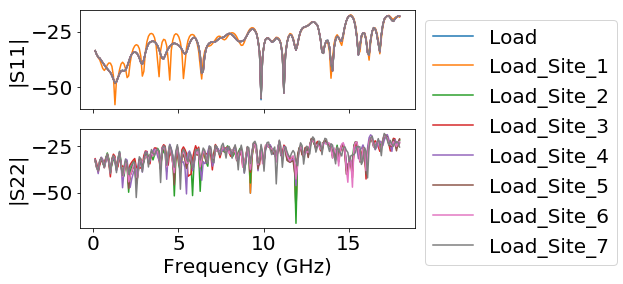

In [52]:
fig, axes = plt.subplots(nrows=2, ncols=1,
                                   sharex=True)
for index,s2p in enumerate(load_list):
    s2p.change_data_format("DB")
    axes[0].plot(10**-9*np.array(s2p["Frequency"]),s2p["dbS11"],label=name_list[index])
    axes[1].plot(10**-9*np.array(s2p["Frequency"]),s2p["dbS22"],label=name_list[index])
axes[0].set_ylabel("|S11|")
axes[1].set_ylabel("|S22|")
plt.xlabel("Frequency (GHz)")
axes[0].legend(bbox_to_anchor=(1, 1))

plt.show()